### Inference on the trained model ###

In [1]:
import sys
import os
import numpy as np
import json
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

# PyTorch
import torch

# Hugging Face Library
from transformers import RTDetrV2ForObjectDetection, RTDetrImageProcessor

%load_ext autoreload
%autoreload 2
import computervision
from computervision.imageproc import is_image, ImageData, clipxywh, xyxy2xywh
from computervision.datasets import DTRdataset, get_gpu_info
from computervision.transformations import AugmentationTransform

print(f'Project version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:801: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Project version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
# Check GPU availability
device, device_str = get_gpu_info()
print(f'Current device {device}')

CUDA available: False
Number of GPUs found:  0
Current device cpu


/usr/local/lib/python3.12/dist-packages/torch/cuda/__init__.py:801: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey'):
    offset_xy = (10, 100)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

In [4]:
# Test images and annotations
data_dir = os.path.join(os.environ.get('HOME'), 'data')
image_dir = os.path.join(data_dir, 'dentex', 'cropped', 'test')
annotation_file_name = 'train_quadrant_enumeration_test_set.parquet'
annotation_file = os.path.join(image_dir, annotation_file_name)
df = pd.read_parquet(annotation_file)
df = df.loc[df['dset'] == 'test']

# Model and the checkpoint (change this path for your own model)
# model_dir = os.path.join(data_dir, 'model')
model_name = 'rtdetr_250311_06'
model_dir = os.path.join(os.environ.get('HOME'), 'data_model', model_name)
json_file_name = 'rtdetr_250928_01.json'
json_file = os.path.join(model_dir, json_file_name)

# Save the predictions in the model directory
output_dir = os.path.join(model_dir, 'testresults')
Path(output_dir).mkdir(exist_ok=True, parents=True)

with open(json_file, mode='r') as fl:
    parameters = json.load(fl)

model_info = parameters.get('model_info')
processor_params = parameters.get('processor_params')

# Class ID to label conversion
id2label = {int(k): int(v) for k, v in parameters.get('id2label').items()}
label2id = {v: k for k, v in id2label.items()}

In [5]:
# Load the image processor
hf_checkpoint = model_info.get('hf_checkpoint')

image_processor = RTDetrImageProcessor.\
    from_pretrained(hf_checkpoint)

#image_processor = RTDetrImageProcessor.\
#    from_pretrained(hf_checkpoint, **processor_params)

# Load the model from checkpoint
checkpoint_name = 'checkpoint-10140'
checkpoint_file = os.path.join(model_dir, checkpoint_name)
model = RTDetrV2ForObjectDetection.from_pretrained(checkpoint_file).to(device)

In [6]:
# HSDM data
# Column names for the annotation files
# label_col = 'pos'
# file_name_col = 'multi_file'
# bbox_col = 'bbox'
# parquet_file_name = 'objectdata_240921_clean_ide.parquet'
# xrays_dir = os.path.join(os.environ.get('HOME'), 'data_model', 'dataset_object_240921')
# quadrants_file = os.path.join(xrays_dir, parquet_file_name)
# df_quadrants = pd.read_parquet(quadrants_file)
# file_name_list = sorted(list(df_quadrants[file_name_col].unique()))
# display(df_quadrants.head(2))
# print(len(file_name_list))

# Quadrants data (the images we trained on)
label_col = 'ada'
file_name_col = 'file_name'
bbox_col = 'bbox'
dset_dir = 'dset'
parquet_file_name = 'train_quadrant_enumeration_dset.parquet'
xrays_dir = os.path.join(data_dir, 'dentex', 'cropped')
quadrants_file = os.path.join(xrays_dir, parquet_file_name)
df_quadrants = pd.read_parquet(quadrants_file)
file_name_list = sorted(list(df_quadrants.loc[
    (df_quadrants[dset_dir] == 'test') &
    (df_quadrants['quadrants'] == 2), 'file_name'].unique()))
display(df_quadrants.head())
print(len(file_name_list))

# Let's filter the images that we want to use for testing
# file_name_list = sorted(list(df.loc[
#     (df['dset'] == 'test') & 
#     (df['quadrants'] == 1) & 
#     (df['transformation'] == 6), 'file_name'].unique()))

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada,dset
0,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",494,779,train_0_01.png,train_0,1,1,1,11,8,train
1,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",494,779,train_0_01.png,train_0,1,1,2,12,7,train
2,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",494,779,train_0_01.png,train_0,1,1,3,13,6,train
3,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",494,779,train_0_01.png,train_0,1,1,4,14,5,train
4,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",494,779,train_0_01.png,train_0,1,1,5,15,4,train


20


Image 1 / 20


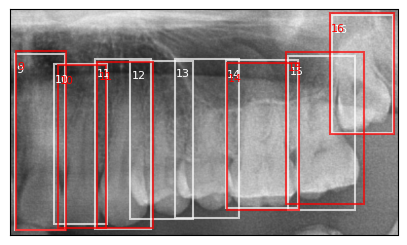

Image 2 / 20


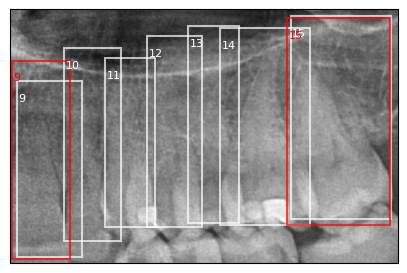

Image 3 / 20


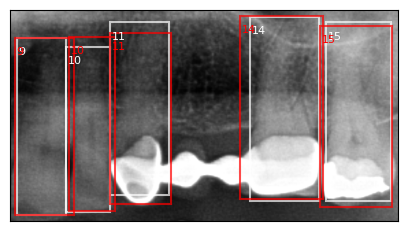

Image 4 / 20


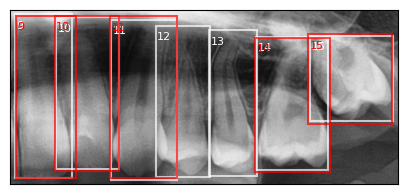

Image 5 / 20


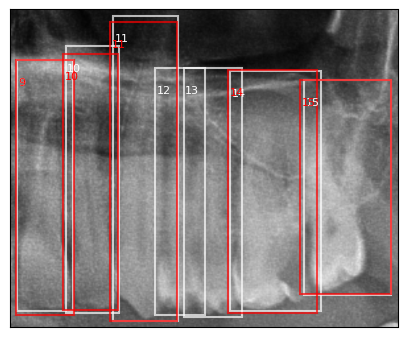

Image 6 / 20


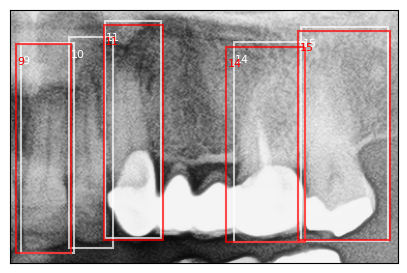

Image 7 / 20


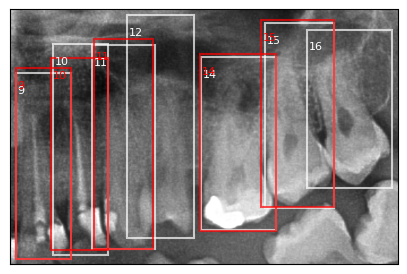

Image 8 / 20


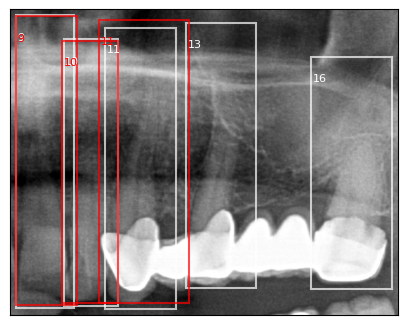

Image 9 / 20


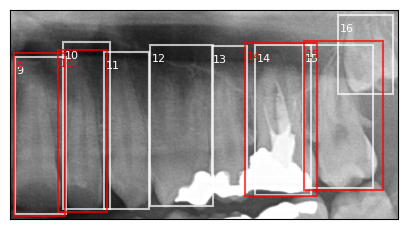

Image 10 / 20


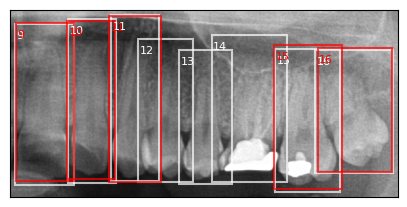

Image 11 / 20


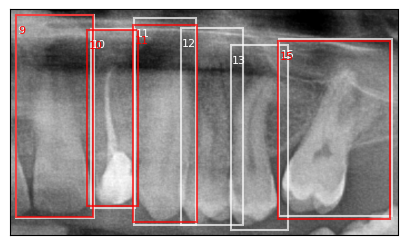

Image 12 / 20


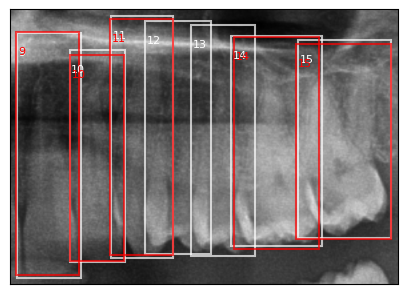

Image 13 / 20


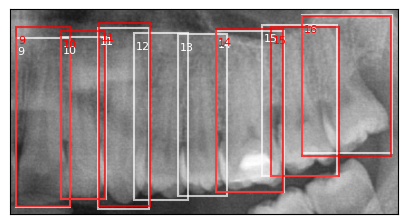

Image 14 / 20


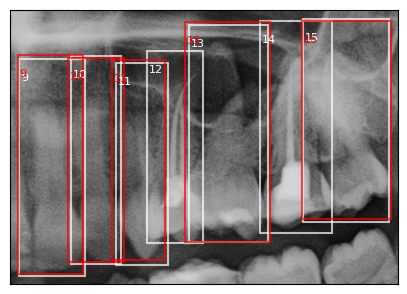

Image 15 / 20


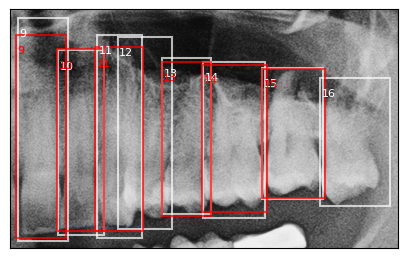

Image 16 / 20


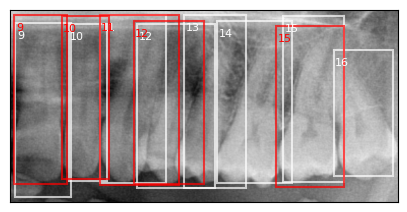

Image 17 / 20


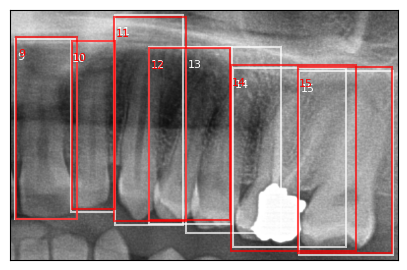

Image 18 / 20


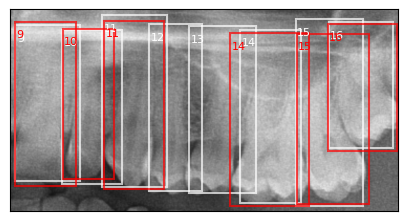

Image 19 / 20


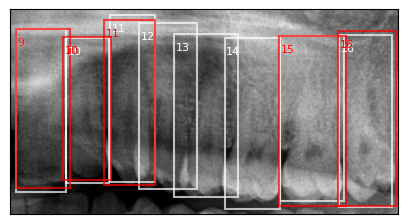

In [7]:
# Let's pick an image and get the ground truth data
for f, file_name in enumerate(file_name_list[:19]):
    # f = 8
    # file_name = file_name_list[f]
    print(f'Image {f+1} / {len(file_name_list)}')
    file = os.path.join(xrays_dir, file_name)
    df_file = df_quadrants.loc[df_quadrants[file_name_col] == file_name]
    box_list = df_file[bbox_col].tolist()
    pos_list = df_file[label_col].tolist()
    
    im = ImageData().load_image(file)
    im = ImageData().np2color(im)
    
    im_input = image_processor(im, return_tensors='pt').to(device)
    with torch.no_grad():
        model_output = model(**im_input)
    threshold = 0.3
    results = image_processor.\
        post_process_object_detection(model_output, 
                                      target_sizes=torch.tensor([(im.shape[0], im.shape[1])]), 
                                      threshold=threshold)
    
    output = results[0]
    scores = output.get('scores').cpu().numpy()
    labels = output.get('labels').cpu().numpy()
    output_pos_list = [id2label.get(i) for i in labels]
    xlim, ylim = (0, im.shape[1]), (0, im.shape[0])
    output_box_list = list(output.get('boxes').cpu().numpy())
    output_box_list = [clipxywh(xyxy2xywh(list(box)), xlim=xlim, ylim=ylim, decimals=0) for box in output_box_list]
    
    output_df = pd.DataFrame({'pred_bbox': output_box_list,
                              'pred_ada': output_pos_list,
                              'score': scores})
    output_df = output_df.assign(file_name=file_name)
    
    output_df = output_df.\
        sort_values(by=['pred_ada', 'score'], ascending=False).\
        groupby(by='pred_ada').first().reset_index(drop=False)
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    ax = plot_boxes(image=im, box_list=box_list, ax=ax, label_list=pos_list, color='w')
    ax = plot_boxes(image=im, 
                    box_list=output_df['pred_bbox'].tolist(), 
                    label_list=output_df['pred_ada'].tolist(), 
                    ax=ax,
                    color='r')
    plt.show()

In [8]:
# Run the image through the model
# First, the image processor
im_input = image_processor(im, return_tensors='pt').to(device)

# Then, we can run the image through the trained model
with torch.no_grad():
    model_output = model(**im_input)

# Post-processing: Non-Maximum Suppression (NMS)

# SET THE SCORE THRESHOLD TO KEEP OPJECT DETECTION PREDICTIONS
threshold = 0.3
results = image_processor.\
    post_process_object_detection(model_output, 
                                  target_sizes=torch.tensor([(im.shape[0], im.shape[1])]), 
                                  threshold=threshold)

print(f'Number of bounding boxes for model output: {len(model_output.get("pred_boxes")[0])}')
print(list(results[0].keys()))
print(f'Number of bounding boxes after post-processing: {len(results[0].get("boxes"))}')
print()

display(results)

Number of bounding boxes for model output: 300
['scores', 'labels', 'boxes']
Number of bounding boxes after post-processing: 5



[{'scores': tensor([0.5517, 0.3960, 0.3937, 0.3535, 0.3024]),
  'labels': tensor([14,  8, 10,  9, 15]),
  'boxes': tensor([[503.7090,  49.4768, 629.6835, 367.2672],
          [ 10.0559,  36.8493, 111.6507, 334.0231],
          [176.5041,  19.9608, 270.2646, 328.3048],
          [ 99.1274,  52.0231, 189.2312, 319.1325],
          [614.2458,  40.8522, 722.1079, 367.6703]])}]

,pred_ada,pred_bbox,score,file_name
0,9,"[10, 36, 101, 298]",0.396045,train_618_02.png
1,10,"[99, 52, 90, 267]",0.353496,train_618_02.png
2,11,"[176, 19, 94, 309]",0.393701,train_618_02.png
3,15,"[503, 49, 126, 318]",0.551701,train_618_02.png
4,16,"[614, 40, 108, 327]",0.302404,train_618_02.png


Pred: 1/5 Score: 0.3960445523262024 Pos: 9


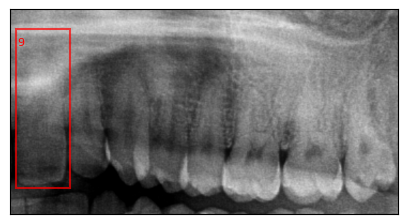

Pred: 2/5 Score: 0.35349586606025696 Pos: 10


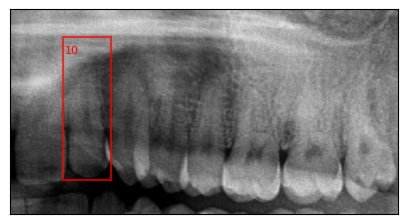

Pred: 3/5 Score: 0.39370137453079224 Pos: 11


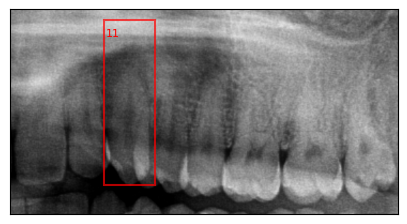

Pred: 4/5 Score: 0.5517008900642395 Pos: 15


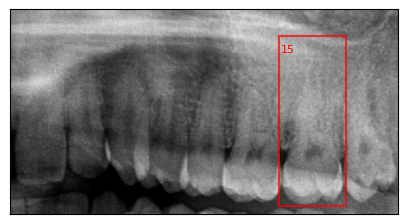

Pred: 5/5 Score: 0.3024044632911682 Pos: 16


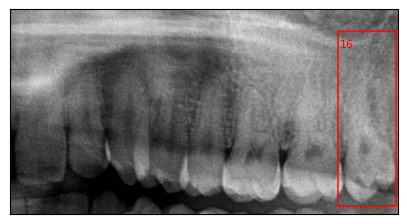

In [9]:
# Get the predictions ready for display
output = results[0]
scores = output.get('scores').cpu().numpy()
labels = output.get('labels').cpu().numpy()
output_pos_list = [id2label.get(i) for i in labels]

# We need to convert the output of the bounding box coordinates into lists of integers
xlim, ylim = (0, im.shape[1]), (0, im.shape[0])
output_box_list = list(output.get('boxes').cpu().numpy())
output_box_list = [clipxywh(xyxy2xywh(list(box)), xlim=xlim, ylim=ylim, decimals=0) for box in output_box_list]

# Let's put the predictions into a data frame
output_df = pd.DataFrame({'pred_bbox': output_box_list,
                          'pred_ada': output_pos_list,
                          'score': scores})
output_df = output_df.assign(file_name=file_name)

# We sort the predictions and take for each position the bounding box with the highest score
output_df = output_df.\
    sort_values(by=['pred_ada', 'score'], ascending=False).\
    groupby(by='pred_ada').first().reset_index(drop=False)

display(output_df)

for p in range(len(output_df)):
    score = output_df['score'].tolist()[p]
    pos = output_df['pred_ada'].tolist()[p]
    box = output_df['pred_bbox'].tolist()[p]
    print(f'Pred: {p+1}/{len(labels)} Score: {score} Pos: {pos}')
    fig, ax = plt.subplots(figsize=(5, 5))
    ax = plot_boxes(image=im, box_list=[box], ax=ax, label_list=[pos], color='r')
    plt.show()